In [23]:
import numpy as np
import gensim
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Embedding, Flatten, merge, SimpleRNN
from keras.optimizers import Adam
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.visualize_util import plot
from keras.utils.visualize_util import model_to_dot
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
import pickle
import pandas as pd

In [24]:
corpora = gensim.corpora.Dictionary.load('./data/corpora.dat')
vocab_size = len(corpora)
print('Number of words in corpora: %d'%(vocab_size))

Number of words in corpora: 26


In [25]:
tmp = list(corpora.items())

In [26]:
#the_filename = './data/wonderland.txt.dat'
the_filename = './data/test.txt.dat'
with open(the_filename, 'rb') as f:
    text = pickle.load(f)

### Generate words patterns - 2 words model

In [27]:
cs = 2

In [28]:
c_in_dat = [[text[i+n] for i in range(0, len(text)-cs, cs)]
            for n in range(cs)]

In [29]:
c_out_dat = [text[i+cs] for i in range(0, len(text)-cs, cs)]

In [30]:
print( [corpora.id2token[text[i+0]] for i in range(0, len(text)-cs, cs)] )
print( [corpora.id2token[text[i+1]] for i in range(0, len(text)-cs, cs)] )
print( [corpora.id2token[text[i+cs]] for i in range(0, len(text)-cs, cs)] )

['One', 'three', 'five', 'seven', 'nine', '.', 'quick', 'fox', 'over', 'lazy', '.', 'are', '?', 'are']
['two', 'four', 'six', 'eight', 'ten', 'The', 'brown', 'jumps', 'a', 'dog', 'How', 'you', 'What', 'you']
['three', 'five', 'seven', 'nine', '.', 'quick', 'fox', 'over', 'lazy', '.', 'are', '?', 'are', 'doing']


In [31]:
xs = [np.stack(c[:-2]) for c in c_in_dat]

In [32]:
len(xs), xs[0].shape

(2, (12,))

In [33]:
y = np.stack(c_out_dat[:-2])

In [34]:
[xs[n][:cs] for n in range(cs)]

[array([2, 4]), array([0, 8])]

In [35]:
y[:cs]

array([4, 3])

In [36]:
n_hidden=256
n_fac=4

In [37]:
model=Sequential([
        Embedding(vocab_size, n_fac, input_length=cs),
        SimpleRNN(n_hidden, activation='relu', inner_init='identity'),
        Dense(vocab_size, activation='softmax')
    ])

In [38]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam())

In [39]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2 (Embedding)          (None, 2, 4)          104         embedding_input_2[0][0]          
____________________________________________________________________________________________________
simplernn_2 (SimpleRNN)          (None, 256)           66816       embedding_2[0][0]                
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 26)            6682        simplernn_2[0][0]                
Total params: 73602
____________________________________________________________________________________________________


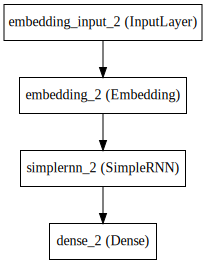

In [40]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [41]:
model.fit(np.stack(xs,1), y, batch_size=1, nb_epoch=100)

Epoch 1/100
12/12 [==============================] - 0s - loss: 3.2643     
Epoch 2/100
12/12 [==============================] - 0s - loss: 3.2095     
Epoch 3/100
12/12 [==============================] - 0s - loss: 3.1524     
Epoch 4/100
12/12 [==============================] - 0s - loss: 3.0354     
Epoch 5/100
12/12 [==============================] - 0s - loss: 2.8294     
Epoch 6/100
12/12 [==============================] - 0s - loss: 2.5857     
Epoch 7/100
12/12 [==============================] - 0s - loss: 2.3543     
Epoch 8/100
12/12 [==============================] - 0s - loss: 2.2121     
Epoch 9/100
12/12 [==============================] - 0s - loss: 2.0710     
Epoch 10/100
12/12 [==============================] - 0s - loss: 1.9254     
Epoch 11/100
12/12 [==============================] - 0s - loss: 1.7653     
Epoch 12/100
12/12 [==============================] - 0s - loss: 1.5966     
Epoch 13/100
12/12 [==============================] - 0s - loss: 1.4718     
Epoch 14

In [42]:
model.save('./models/dev_fast_ai_first_RNN_keras.h5')

### Test model

In [43]:
def get_next_keras(inp):
    idxs = [corpora.token2id[c] for c in inp]
    arrs = np.array(idxs)[np.newaxis,:]
    p = model.predict(arrs)[0]
    return corpora.id2token[np.argmax(p)]

In [44]:
get_next_keras(['One', 'two'])

'three'

In [45]:
test_cases_text = pd.read_csv('./data/test_cases_text.csv')
pred = []
for index, row in test_cases_text.iterrows():
    #print( '%s %s'%(row['in_0'], row['in_1']))
    inp = [row['in_0'], row['in_1']]
    #print(inp)
    tmp = get_next_keras(inp)
    pred.append(tmp)
test_cases_text['predicted'] = pred

In [46]:
test_cases_text[test_cases_text.out==test_cases_text.predicted]

,in_0,in_1,out,predicted
0,One,two,three,three
2,three,four,five,five
4,five,six,seven,seven
6,seven,eight,nine,nine
8,nine,ten,.,.
10,.,The,quick,quick
12,quick,brown,fox,fox
14,fox,jumps,over,over
16,over,a,lazy,lazy
18,lazy,dog,.,.


In [47]:
true_cnt = len(test_cases_text[test_cases_text.out==test_cases_text.predicted].index) * 1.0
all_cnt = len(test_cases_text.index) * 1.0
print('True cnt: %d All cnt %d'%(true_cnt, all_cnt))
print("Precision: %.2f"%( true_cnt/all_cnt))

True cnt: 12 All cnt 28
Precision: 0.43
